In [1]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

from src.tower import Tower
from src.embedding import EmbeddingModel
from src.recommender import RecommenderModel
from src.utils.utilities import (
    dataframe_to_Dataset,
    train_test_split,
    plot_history,
)


RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)

2024-08-29 12:05:38.276281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 12:05:38.291863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 12:05:38.296011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 12:05:38.309558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 12:05:39.360786: W tensorflow/compiler/tf2

In [3]:
# Ratings
ratings_df = pd.read_parquet('data/100k-ratings.parquet')
ratings_columns = [
    'bucketized_user_age',
    # 'movie_genres',
    'movie_id',
    'movie_title',
    'raw_user_age',
    'timestamp',
    'user_gender',
    'user_id',
    'user_occupation_label',
    'user_occupation_text',
    'user_rating',
    'user_zip_code'
]
ratings_df = ratings_df.iloc[:100]
ratings_dataset = dataframe_to_Dataset(ratings_df, ratings_columns)

I0000 00:00:1724920540.960309  138048 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724920540.992779  138048 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724920540.992872  138048 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724920540.996102  138048 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724920540.996166  138048 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [4]:
# Ratings
movies_df = pd.read_parquet('data/100k-movies.parquet')
movies_columns = [
    # 'movie_genres',
    'movie_id',
    'movie_title'
]
movies_dataset = dataframe_to_Dataset(movies_df, movies_columns)

In [5]:
# Feature selection
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        # `user_id` is useful as a user identifier.
        'user_id': rating['user_id'],
        # `movie_id` is useful as a movie identifier.
        'movie_id': rating['movie_id'],
        # `movie_title` is useful as a textual information about the movie.
        'movie_title': rating['movie_title'],
        # `user_rating` shows the user's level of interest to a movie.
        'user_rating': rating['user_rating'],
        # `timestamp` will allow us to model the effect of time.
        'timestamp': rating['timestamp'],
        # Target Variable
        'score': rating['user_rating']
    }
)

### Dataset Splitting

In [6]:
# Train and validation splits
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = 0.8,
    random_state = RANDOM_STATE,
    buffer_size = tf.data.UNKNOWN_CARDINALITY
)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 80
validset_size: 20


In [7]:
user_embedding_model = EmbeddingModel(
    dataset = ratings_dataset,
    str_features = ['user_id'],
    text_features = [],
    embedding_dim = 4,
)

movie_embedding_model = EmbeddingModel(
    dataset = ratings_dataset,
    str_features = ['movie_id'],
    text_features = ['movie_title'],
    embedding_dim = 4,
)

[DEBUG - 2024-08-29 12:05:43]	`EmbeddingModel.__create_str_embedding_layer()` executed in 0.4 seconds.
[DEBUG - 2024-08-29 12:05:43]	`EmbeddingModel.__create_str_embedding_layer()` executed in 0.3 seconds.
[DEBUG - 2024-08-29 12:05:43]	`EmbeddingModel.__create_text_embedding_layer()` executed in 0.6 seconds.


In [8]:
deep_layers = tf.keras.Sequential([
    tf.keras.layers.Dense(8),
])

cross_layer = tfrs.layers.dcn.Cross(
    projection_dim = 8,
    kernel_initializer = "glorot_uniform"
)

In [9]:
candidate_tower = Tower(
    embedding_model = movie_embedding_model,
    cross_layer = cross_layer,
    deep_layers = deep_layers,
)

query_tower = Tower(
    embedding_model = user_embedding_model,
    cross_layer = cross_layer,
    deep_layers = deep_layers,
)

In [10]:
factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    # dataset of candidate embeddings from which candidates should be retrieved
    candidates = ratings_dataset.batch(128).map(
        candidate_tower
    )
)

In [11]:
# Ranking
ranking_task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Retrieval
retrieval_task = tfrs.tasks.Retrieval(
    metrics = [
        factorized_top_k_metrics
    ]
)

model = RecommenderModel(
    query_tower = query_tower,
    candidate_tower = candidate_tower,
    ranking_task = ranking_task,
    retrieval_weight = 1.0,
    retrieval_task = retrieval_task,
)

optimizer = tf.keras.optimizers.Adagrad(learning_rate = 0.1)
model.compile(optimizer = optimizer)

In [12]:
# Shuffle the training data for each epoch.
# Batch and cache both the training and evaluation data.
# `cache()` method caches the elements in the dataset in memory. To caches data
# in a file pass the `filename` argument to the method: cache(filename='')
# The first time the dataset is iterated over, its elements will be cached
# either in the specified file or in memory. Subsequent iterations will use the
# cached data.
cached_ratings_trainset = ratings_trainset.shuffle(100_000).batch(1024).cache()
cached_ratings_validset = ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3
)

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = 1,
    epochs = 10,
    callbacks = [
        early_stopping_callback
    ]
)

Epoch 1/10


I0000 00:00:1724920547.366056  138181 service.cc:146] XLA service 0x7f1b8c33e3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724920547.366117  138181 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-08-29 12:05:47.372051: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-29 12:05:47.384556: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1724920547.464299  138181 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 5s 5s/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 364.7427 - regularization_loss: 0.0000e+00 - total_loss: 364.7427 - val_root_mean_squared_error: 3.2582 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 0.1000 - val_factorized_top_k/top_50_categorical_accuracy: 0.5000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 70.5320 - val_regularization_loss: 0.0000e+00 - val_total_loss: 70.5320
Epoch 2/10
1/1 [==============================] - 0s 169ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k

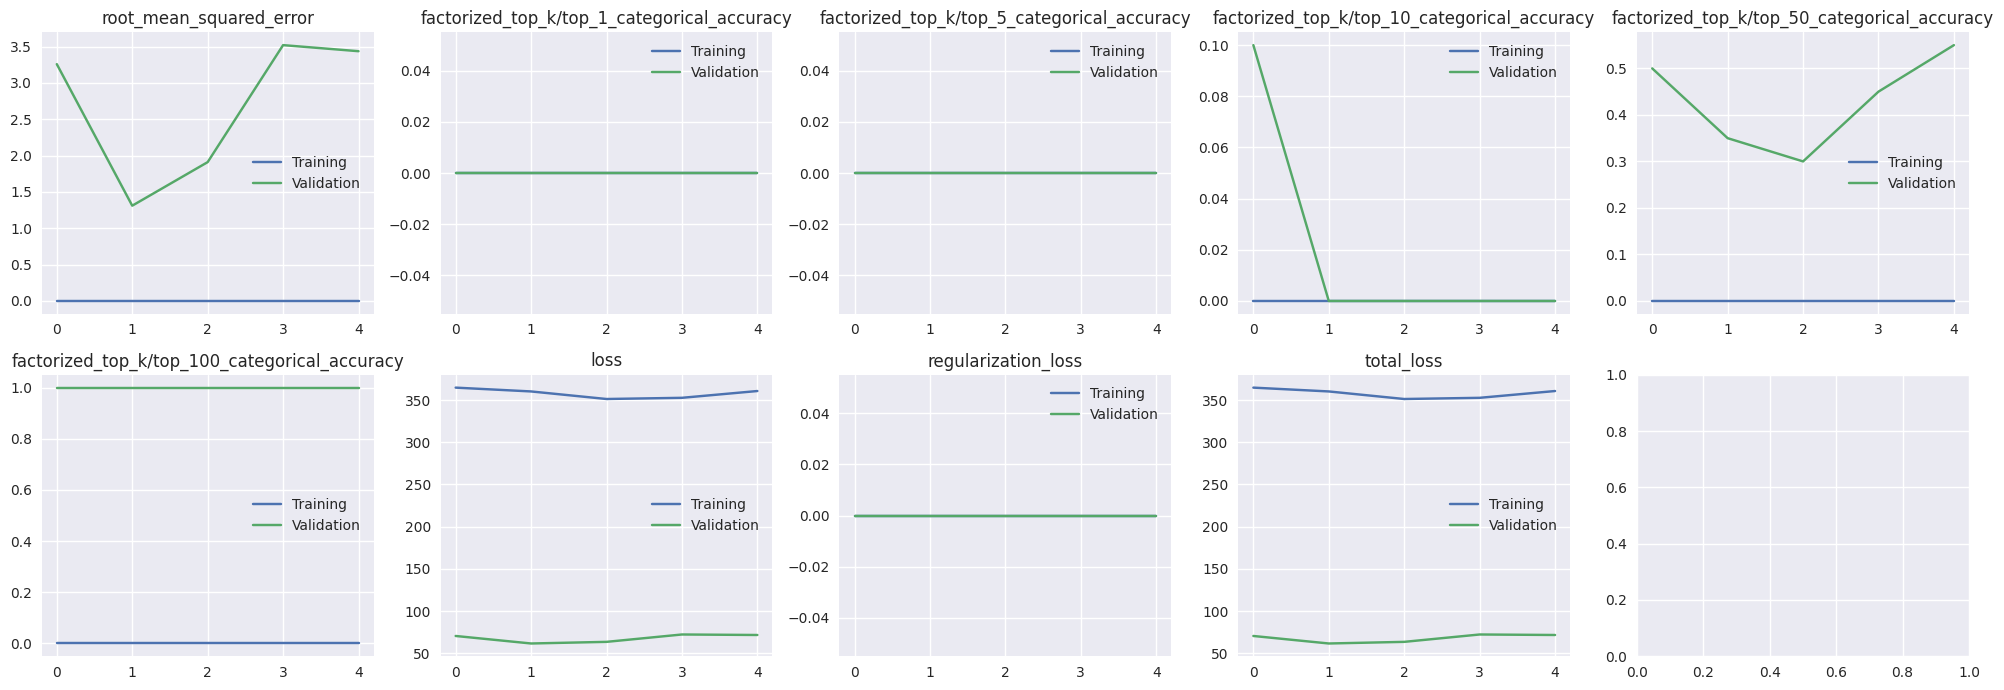

In [13]:
plot_history(history = history)

In [14]:
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    model.query_tower,
    k = 10,
)

scann_layer.index_from_dataset(
  tf.data.Dataset.zip(
      (
          movies_dataset.map(lambda movie: movie['movie_id']).batch(100),
          movies_dataset.batch(100).map(model.candidate_tower)
      )
  )
)

2024-08-29 12:05:52.028559: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-29 12:05:52.041781: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 1682
2024-08-29 12:05:52.042607: W scann/utils/gmm_utils.cc:920] Could not normalize centroid due to zero norm or empty or zero-weight partition.
2024-08-29 12:05:52.044461: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:89] PartitionerFactory ran in 2.622943ms.


In [15]:

user_id = '41'
afinity_scores, movie_ids = scann_layer(
    {
        'user_id': tf.convert_to_tensor([user_id])
    }
)

scann_result = list(zip(movie_ids[0], afinity_scores[0]))

for movie_id, score in scann_result:

    pred = model({
        "user_id": tf.convert_to_tensor([user_id]),
        "movie_id": tf.convert_to_tensor([movie_id]),
        "movie_title": tf.convert_to_tensor(["God Father"])
    })
    _, _, rating = pred

    print(f"Movie {movie_id} (afinity: {score:.2f}): {rating[0][0]:.2f}")

Movie b'1028' (afinity: 0.02): 0.51
Movie b'95' (afinity: 0.02): 0.49
Movie b'13' (afinity: 0.02): 0.48
Movie b'638' (afinity: 0.02): 0.54
Movie b'491' (afinity: 0.02): 0.52
Movie b'540' (afinity: 0.02): 0.50
Movie b'659' (afinity: 0.02): 0.51
Movie b'724' (afinity: 0.02): 0.54
Movie b'465' (afinity: 0.02): 0.52
Movie b'200' (afinity: 0.02): 0.50
